In [32]:
import os
import itertools
import time
import json
import tqdm

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold, train_test_split

# Feature scaling, required for non-tree-based models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize

# Encoding categorical data for non-tree-based models
from sklearn.preprocessing import OneHotEncoder

#from fbprophet import Prophet

In [33]:
marketing = pd.read_csv('../datasets/marketing.csv', low_memory=True, thousands=',')

In [34]:
marketing["data_date"] = marketing.data_date.map(lambda data:str(data))
marketing["data_date"] = pd.to_datetime(marketing.data_date)

In [35]:
marketing

,data_date,marketing,plan
0,2017-03-01,-1,0
1,2017-03-02,-1,0
2,2017-03-03,-1,0
3,2017-03-04,-1,0
4,2017-03-05,-1,0
5,2017-03-06,-1,0
6,2017-03-07,-1,0
7,2017-03-08,-1,0
8,2017-03-09,-1,0
9,2017-03-10,-1,0


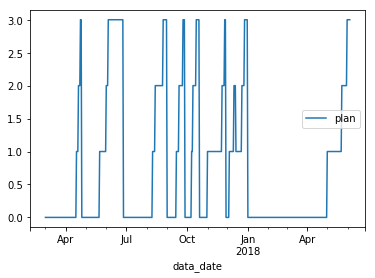

In [36]:
marketing.plot(x = 'data_date', y = 'plan')

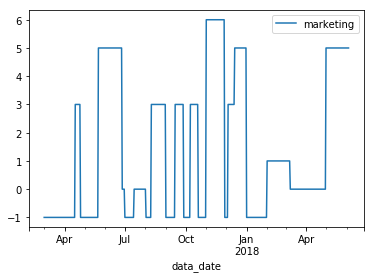

In [37]:
marketing.plot(x = 'data_date', y = 'marketing')

In [47]:
ds = marketing[marketing['marketing'] == 1]['data_date']
marketing_1 = pd.DataFrame({
  'holiday': 'marketing__1',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

ds = marketing[marketing['marketing'] == 3]['data_date']
marketing_3 = pd.DataFrame({
  'holiday': 'marketing_3',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

ds = marketing[marketing['marketing'] == 5]['data_date']
marketing_5 = pd.DataFrame({
  'holiday': 'marketing_5',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

ds = marketing[marketing['marketing'] == 6]['data_date']
marketing_6 = pd.DataFrame({
  'holiday': 'marketing_6',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

In [49]:
ds = marketing[marketing['plan'] == 1]['data_date']
plan_1 = pd.DataFrame({
  'holiday': 'plan_1',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

ds = marketing[marketing['plan'] == 2]['data_date']
plan_2 = pd.DataFrame({
  'holiday': 'plan_2',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

ds = marketing[marketing['plan'] == 3]['data_date']
plan_3 = pd.DataFrame({
  'holiday': 'plan_3',
  'ds': ds,
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((marketing_1, marketing_3, marketing_5, marketing_6, plan_1, plan_2, plan_3))
holidays

,ds,holiday,lower_window,upper_window
337,2018-02-01,marketing__1,0,1
338,2018-02-02,marketing__1,0,1
339,2018-02-03,marketing__1,0,1
340,2018-02-04,marketing__1,0,1
341,2018-02-05,marketing__1,0,1
342,2018-02-06,marketing__1,0,1
343,2018-02-07,marketing__1,0,1
344,2018-02-08,marketing__1,0,1
345,2018-02-09,marketing__1,0,1
346,2018-02-10,marketing__1,0,1
